In [1]:
import pandas as pd
import numpy as np

import re

import collections

import string
import nltk
import unicodedata
import spacy

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sentistrength import PySentiStr

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.feature_extraction.text import TfidfVectorizer

from collections import OrderedDict
from collections import Counter

import gensim
from gensim.models import Word2Vec
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

import subprocess

## Upload database

In [2]:
df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

In [3]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [5]:
df.drop(['id', 'dateAdded', 'dateUpdated', 'brand', 'asins', 'keys', 'categories', 'imageURLs', 'manufacturer', 
         'manufacturerNumber', 'reviews.username', 'reviews.sourceURLs', 'reviews.id'], axis=1, inplace=True)

## Clean text

In [6]:
df['reviews.text'] = df['reviews.text'].apply(lambda x: x.lower())

In [7]:
def remove_stopwords(word):
    
    normalize = ' '.join([w for w in word if w.lower() not in stopwords])
    return normalize

In [8]:
def remove_acentuacao(word):
    
    acentuacao = ''.join(ch for ch in unicodedata.normalize('NFKD', word)
                         if not unicodedata.combining(ch))
    
    return acentuacao

In [9]:
def lematizacao(word):
    sp = spacy.load('en_core_web_sm')
    doc = sp(word)
    lemma_sent = " ".join([token.lemma_ for token in doc])
    
    return lemma_sent

In [10]:
ponctuation = set(string.punctuation)

In [11]:
stopwords = list(set(stopwords.words('english')))

In [12]:
df['reviews_text_normalize'] = df['reviews.text'].apply(lambda x:remove_stopwords(word_tokenize(x)))

In [13]:
df['reviews_text_normalize'] = df['reviews_text_normalize'].apply(lambda x:remove_acentuacao(x))

In [14]:
df['reviews_text_normalize'] = df['reviews_text_normalize'].apply(lambda x:lematizacao(x))

## Preprocessing

In [15]:
df['name_normalize'] = df['name'].apply(lambda x: x.lower())

In [16]:
df.head()

,name,primaryCategories,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,sourceURLs,reviews_text_normalize,name_normalize
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,0,3,i thought it would be as big as small paper bu...,Too small,https://www.newegg.com/Product/Product.aspx%25...,thought would big small paper turn like palm ....,"amazon kindle e-reader 6"" wifi (8th generation..."
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,0,5,this kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,https://www.newegg.com/Product/Product.aspx%25...,kindle light easy use especially beach ! ! !,"amazon kindle e-reader 6"" wifi (8th generation..."
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,0,4,didnt know how much i'd use a kindle so went f...,Great for the price,https://www.newegg.com/Product/Product.aspx%25...,do not know much 'd use kindle go low end . -P...,"amazon kindle e-reader 6"" wifi (8th generation..."
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,3,5,i am 100 happy with my purchase. i caught it o...,A Great Buy,https://www.newegg.com/Product/Product.aspx%25...,100 happy purchase . catch sale really good pr...,"amazon kindle e-reader 6"" wifi (8th generation..."
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,0,5,solid entry level kindle. great for kids. gift...,Solid entry-level Kindle. Great for kids,https://www.newegg.com/Product/Product.aspx%25...,solid entry level kindle . great kid . gifted ...,"amazon kindle e-reader 6"" wifi (8th generation..."


In [17]:
product = ['Kindle', 'Tablet', 'Echo', 'Fire TV', 'Power Adapter', 'Tap']

In [18]:
def getNormalizeProduct(text):
    for i in process.extractBests(text.lower(), product, score_cutoff=60):
        return i

In [19]:
df['name_normalize'] = df['name_normalize'].apply(lambda x: getNormalizeProduct(x)) 

In [20]:
df.head()

,name,primaryCategories,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,sourceURLs,reviews_text_normalize,name_normalize
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,0,3,i thought it would be as big as small paper bu...,Too small,https://www.newegg.com/Product/Product.aspx%25...,thought would big small paper turn like palm ....,"(Kindle, 60)"
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,0,5,this kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,https://www.newegg.com/Product/Product.aspx%25...,kindle light easy use especially beach ! ! !,"(Kindle, 60)"
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,0,4,didnt know how much i'd use a kindle so went f...,Great for the price,https://www.newegg.com/Product/Product.aspx%25...,do not know much 'd use kindle go low end . -P...,"(Kindle, 60)"
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,3,5,i am 100 happy with my purchase. i caught it o...,A Great Buy,https://www.newegg.com/Product/Product.aspx%25...,100 happy purchase . catch sale really good pr...,"(Kindle, 60)"
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,0,5,solid entry level kindle. great for kids. gift...,Solid entry-level Kindle. Great for kids,https://www.newegg.com/Product/Product.aspx%25...,solid entry level kindle . great kid . gifted ...,"(Kindle, 60)"


In [21]:
def getReplaceNameProduct(text):
    result = ''.join([i for i in text if not i.isdigit()])
    result = re.sub(r"['(,) ']", "", result)
    return result       

In [22]:
df['name_normalize'] = df['name_normalize'].apply(lambda x: getReplaceNameProduct(str(x)))

In [23]:
df.head()

,name,primaryCategories,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,sourceURLs,reviews_text_normalize,name_normalize
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,0,3,i thought it would be as big as small paper bu...,Too small,https://www.newegg.com/Product/Product.aspx%25...,thought would big small paper turn like palm ....,Kindle
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,0,5,this kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,https://www.newegg.com/Product/Product.aspx%25...,kindle light easy use especially beach ! ! !,Kindle
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,0,4,didnt know how much i'd use a kindle so went f...,Great for the price,https://www.newegg.com/Product/Product.aspx%25...,do not know much 'd use kindle go low end . -P...,Kindle
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,3,5,i am 100 happy with my purchase. i caught it o...,A Great Buy,https://www.newegg.com/Product/Product.aspx%25...,100 happy purchase . catch sale really good pr...,Kindle
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,0,5,solid entry level kindle. great for kids. gift...,Solid entry-level Kindle. Great for kids,https://www.newegg.com/Product/Product.aspx%25...,solid entry level kindle . great kid . gifted ...,Kindle


In [24]:
df['name_normalize'].value_counts(normalize=True)

Tablet          0.4850
Echo            0.2870
Kindle          0.1778
Tap             0.0450
PowerAdapter    0.0044
FireTV          0.0008
Name: name_normalize, dtype: float64

*Os produtos que mais foram avaliados foram os Tablets, Echo - Alexa e o Kindle. Foi feito um tratamento nos dados para padronizar o nomes dos produtos, considerando apenas os produtos em si e desconsiderando dados como modelo, cor e conectividade.*

In [25]:
def text_tokenize(text):
    
    '''
        Description: This function receives a raw input text and returns it tokenized.
        Args: 
            - text (string): the raw text to tokenize
        Returns: 
            - tokenized_text (string): tokenized text 
    '''
    
    exclude_tags = ['IN', 'CD', 'MD', 'LS', 'POS', 'PRP$']
    
    tokenized_text = nltk.word_tokenize(text)
    
    pos_tag = nltk.pos_tag(tokenized_text)
    
    normalized = [s for s in tokenized_text if s not in ponctuation
                 
                  if s not in stopwords
                  
                  if len(s) >= 2
                  # It removes words in the vocabulary. The vocabulary is a list of common words in news articles that do not have much meaning in the
                  # overall result

                  # It removes pos_tags elements that are not so important for the overall meaning
                  if s not in exclude_tags

                  # Removes numbers and other special characters
                  if s.isalpha()]
    
    normalized_unique = list(OrderedDict.fromkeys(normalized))
    
    normalized_text = " ".join(word.strip() for word in normalized_unique)
    
    return normalized_text

In [26]:
def get_frequent_words_tfidf(normalized_text):
     
    '''
        Description: This function extracts the most frequent terms from a normalized text using Term-Frequency, 
        Inverse Term-Frequency (TF-IDF) method
        
        Args:
            - normalized_text (string): the normalized text to be analyzed
        
        Returns: 
            - most_common_feats (list): the list of most frequent terms
    '''
    
    tfidf_vect = TfidfVectorizer(
                                # Removes tokens that don't appear at least 2 times
                                min_df=2,
                        
                                # Removes tokens that appear in more than 20% of the documents
                                max_df=0.2,
        
                                # Use CountVectorizor to find three letter tokens, remove stop_words
                                stop_words=stopwords, 
                                    
                                # Creating n-grams from tokens
                                ngram_range=(1, 3))
    
    # Fit and transform
    tf_idf_fitted = tfidf_vect.fit_transform(normalized_text)
    
    # Getting the most frequent terms
    most_common_feats = tfidf_vect.get_feature_names()
    
    scores = zip(most_common_feats, np.asarray(tf_idf_fitted.sum(axis=0)).ravel())
    
    # Sorting the weights by ascending order
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Returns the output
    return sorted_scores

In [27]:
df_tablet = df.loc[df['name_normalize'] == 'Tablet']
df_echo = df.loc[df['name_normalize'] == 'Echo']
df_kindle = df.loc[df['name_normalize'] == 'Kindle']

In [28]:
final_str_tablet = ' '.join([text_tokenize(tokens) for tokens in df_tablet['reviews_text_normalize'].values])
final_str_echo = ' '.join([text_tokenize(tokens) for tokens in df_echo['reviews_text_normalize'].values])
final_str_kindle = ' '.join([text_tokenize(tokens) for tokens in df_kindle['reviews_text_normalize'].values])

In [29]:
most_freq_tablet = get_frequent_words_tfidf(final_str_tablet.split(' '))
most_freq_echo = get_frequent_words_tfidf(final_str_echo.split(' '))
most_freq_kindle = get_frequent_words_tfidf(final_str_kindle.split(' '))

In [30]:
def get_topk_ngrams(text, k, n):
    """
        Description
            This function extracts n-grams from base text and return the top-n most common combinations.
        Params:
            text - the base text to be processed
            k - the number of n-grams to consider
            n - the number of most commmon combinations to analyze
        
        Returns
            ngram_counts - most common n-gram combination
    """
    
    ngram_counts = Counter(nltk.ngrams(text.split(), k))
    return ngram_counts.most_common(n)

In [31]:
get_topk_ngrams(final_str_tablet, 2, 30)

[(('easy', 'use'), 209),
 (('year', 'old'), 194),
 (('kindle', 'fire'), 103),
 (('great', 'tablet'), 95),
 (('love', 'tablet'), 87),
 (('amazon', 'fire'), 63),
 (('work', 'great'), 55),
 (('play', 'game'), 55),
 (('would', 'recommend'), 53),
 (('parental', 'control'), 52),
 (('tablet', 'great'), 52),
 (('work', 'well'), 50),
 (('daughter', 'love'), 49),
 (('love', 'easy'), 49),
 (('read', 'book'), 49),
 (('battery', 'life'), 49),
 (('good', 'tablet'), 47),
 (('love', 'kindle'), 47),
 (('buy', 'tablet'), 47),
 (('son', 'love'), 44),
 (('fire', 'tablet'), 44),
 (('fire', 'hd'), 43),
 (('kid', 'love'), 42),
 (('absolutely', 'love'), 41),
 (('great', 'price'), 39),
 (('old', 'love'), 36),
 (('watch', 'movie'), 34),
 (('amazon', 'prime'), 34),
 (('really', 'enjoy'), 33),
 (('great', 'product'), 33)]

In [32]:
get_topk_ngrams(final_str_echo, 2, 30)

[(('echo', 'show'), 138),
 (('echo', 'plus'), 81),
 (('easy', 'set'), 71),
 (('amazon', 'echo'), 69),
 (('play', 'music'), 58),
 (('smart', 'home'), 54),
 (('great', 'product'), 54),
 (('easy', 'use'), 53),
 (('work', 'great'), 49),
 (('love', 'echo'), 47),
 (('love', 'alexa'), 40),
 (('work', 'well'), 39),
 (('turn', 'light'), 38),
 (('echo', 'dot'), 35),
 (('listen', 'music'), 30),
 (('sound', 'quality'), 27),
 (('great', 'addition'), 26),
 (('ask', 'question'), 25),
 (('video', 'call'), 25),
 (('great', 'sound'), 25),
 (('use', 'alexa'), 24),
 (('show', 'great'), 24),
 (('set', 'use'), 23),
 (('good', 'buy'), 22),
 (('light', 'bulb'), 22),
 (('security', 'camera'), 21),
 (('christmas', 'gift'), 21),
 (('control', 'light'), 21),
 (('video', 'chat'), 20),
 (('really', 'like'), 19)]

In [33]:
get_topk_ngrams(final_str_kindle, 2, 30)

[(('easy', 'use'), 52),
 (('battery', 'life'), 39),
 (('read', 'book'), 30),
 (('year', 'old'), 29),
 (('love', 'kindle'), 22),
 (('work', 'great'), 21),
 (('would', 'recommend'), 20),
 (('great', 'tablet'), 20),
 (('kindle', 'fire'), 19),
 (('love', 'read'), 18),
 (('great', 'product'), 17),
 (('new', 'kindle'), 17),
 (('use', 'kindle'), 16),
 (('easy', 'read'), 16),
 (('great', 'price'), 16),
 (('buy', 'kindle'), 15),
 (('work', 'well'), 15),
 (('old', 'kindle'), 15),
 (('love', 'tablet'), 15),
 (('light', 'weight'), 14),
 (('battery', 'last'), 14),
 (('buy', 'one'), 14),
 (('play', 'game'), 14),
 (('love', 'new'), 13),
 (('buy', 'tablet'), 13),
 (('good', 'product'), 12),
 (('kindle', 'voyage'), 12),
 (('great', 'kid'), 11),
 (('last', 'long'), 11),
 (('long', 'time'), 11)]

## WordCloud

In [34]:
def plot_word_cloud(text):
    plt.figure(figsize=(15, 10))
    wordcloud = WordCloud(width = 1000, height = 500, stopwords=stopwords, 
                          background_color="rgba(255, 255, 255, 0)", 
                          mode="RGBA", max_words=100).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

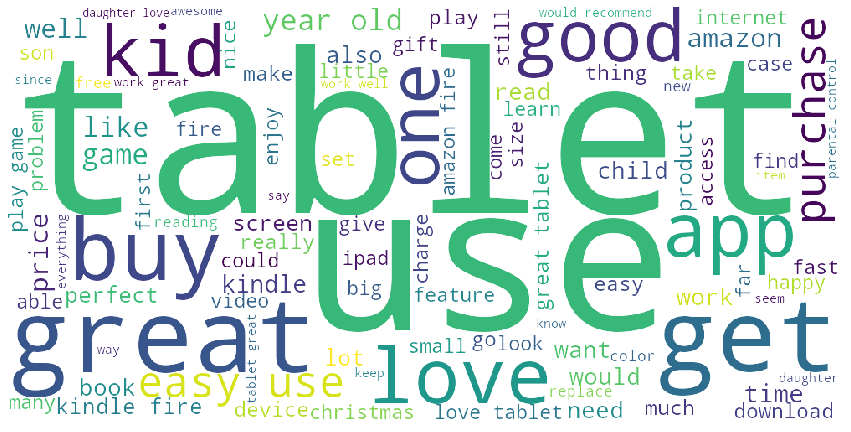

In [35]:
plot_word_cloud(final_str_tablet)

*Nuvem de palavras referente ao produto Tablet, palavras como great e love tiveram destaque na nuvem, o que podemos considerar como um termo bem frequente nas suas avaliações. Dois termos interessante mostra kid e child, mostrando ser um produto bastante efetivo para crianças.*

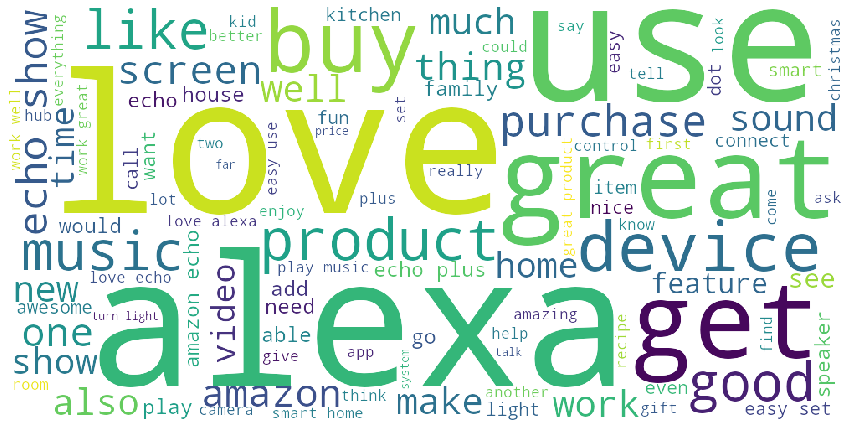

In [36]:
plot_word_cloud(final_str_echo)

*Nuvem de palavras referente ao produto Echo Alexa, o nome do produto aparece em destaque na Nuvem, seguinda de elogios como love, great, awesome, like, good e enjoy. Alguns bigramas foram identificado como smart home, amazon echo, work well, love echo e great product, o que mostra a avaliação positiva deste produto.*

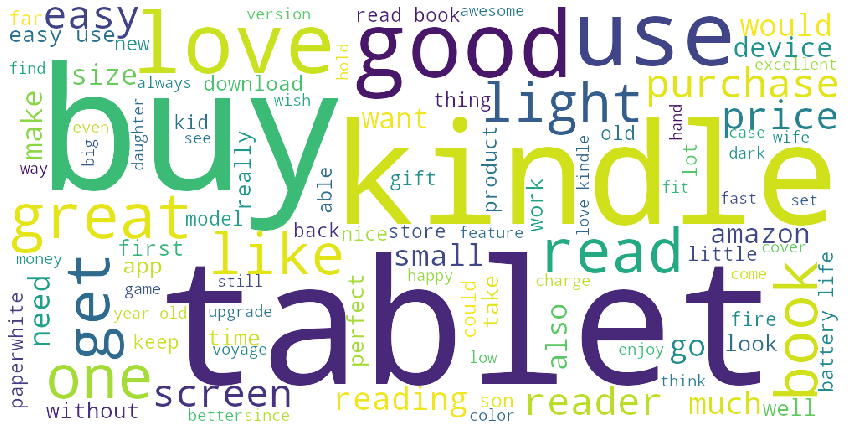

In [37]:
plot_word_cloud(final_str_kindle)

*Nuvem de palavras - Kindle, o nome tablet também aparece bem evidente junto com o nome do produto, além de termos como book, reader, paperwhite, reading, read mostrando termos associados ao produto. Termos como good, love, great, easy, better, enjoy mostrando que o produto apresentou um frequencia alta de palavras positivas em suas avaliações.*

## Sentiment Analysis

In [38]:
def sentistrengthClassifier():
    subprocess.call(['java'])
    senti = PySentiStr()
    senti.setSentiStrengthPath('sentistrength/SentiStrength.jar')
    senti.setSentiStrengthLanguageFolderPath('sentistrength/SentStrength/')
    return senti

In [39]:
classifier = sentistrengthClassifier()

In [40]:
df['sentiment'] = df['reviews_text_normalize'].apply(lambda x: classifier.getSentiment(x))

In [41]:
df['sentiment'] = df['sentiment'].apply(lambda x: str(x).replace('[', '').replace(']', ''))

In [42]:
map_sentimental = {'-1': 'neutro', 
                   '0': 'neutro', 
                   '1': 'neutro', 
                   '-3': 'negativo', 
                   '-2': 'negativo', 
                   '2': 'positivo',
                   '3': 'positivo',
                   '4': 'positivo',
                   '-4': 'negativo'}

In [43]:
df['sentiment'].unique()

array(['1', '0', '2', '-2', '-1', '3', '4', '-3'], dtype=object)

In [44]:
df['sentiment_score'] = df['sentiment'].map(map_sentimental)

In [45]:
df['sentiment_score'].value_counts(normalize=True)

positivo    0.5316
neutro      0.4564
negativo    0.0120
Name: sentiment_score, dtype: float64

In [46]:
df_product_senti = df[['name_normalize', 'sentiment_score']]

In [47]:
df_product_senti.head()

,name_normalize,sentiment_score
0,Kindle,neutro
1,Kindle,neutro
2,Kindle,neutro
3,Kindle,neutro
4,Kindle,positivo


In [48]:
df_product_senti['qtd'] = 1 

In [49]:
df_product_senti_aux = pd.pivot_table(df_product_senti, index='name_normalize', 
                                      columns=['sentiment_score'], aggfunc=np.sum) 

In [50]:
df_product_senti_aux = df_product_senti_aux.reset_index() 

In [51]:
df_product_senti_aux.columns = ['product', 'negativo', 'neutro', 'positivo']

In [52]:
df_product_senti_aux = df_product_senti_aux.sort_values('positivo',ascending=False)

In [53]:
df_product_senti_aux['negativo'] = df_product_senti_aux['negativo'].fillna(0)
df_product_senti_aux['negativo'] = df_product_senti_aux['negativo'].astype(int)
df_product_senti_aux['neutro'] = df_product_senti_aux['neutro'].astype(int)
df_product_senti_aux['positivo'] = df_product_senti_aux['positivo'].astype(int)

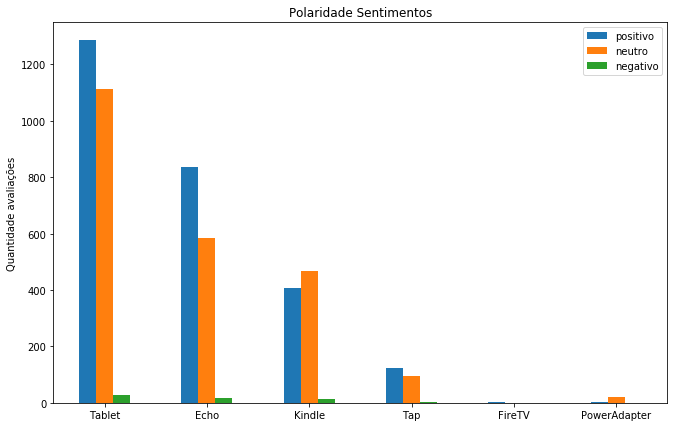

In [57]:
ax = df_product_senti_aux.plot(x="product", y=["positivo", "neutro", "negativo"], kind="bar")
ax.set_ylabel('Quantidade avaliações')
ax.set_xlabel(' ')
ax.set_title('Polaridade Sentimentos')
plt.rcParams['figure.figsize'] = (11,7)
plt.xticks(rotation = 0)
ax.legend()
plt.show()

*Houveram poucas avaliações negativas dos 3 produtos conforme gráfico acima*

In [58]:
df_product_senti_aux.head()

,product,negativo,neutro,positivo
4,Tablet,26,1114,1285
0,Echo,16,584,835
2,Kindle,14,468,407
5,Tap,4,96,125
1,FireTV,0,1,3


In [59]:
df_product_senti_aux['total_positivo'] = (df_product_senti_aux['positivo']/(df_product_senti_aux['negativo'] + df_product_senti_aux['neutro'] + df_product_senti_aux['positivo']))*100
df_product_senti_aux['total_positivo'] = df_product_senti_aux['total_positivo'].round(2)
df_product_senti_aux['total_negativo'] = (df_product_senti_aux['negativo']/(df_product_senti_aux['negativo'] + df_product_senti_aux['neutro'] + df_product_senti_aux['positivo']))*100
df_product_senti_aux['total_negativo'] = df_product_senti_aux['total_negativo'].round(2)
df_product_senti_aux['total_neutro'] = (df_product_senti_aux['neutro']/(df_product_senti_aux['negativo'] + df_product_senti_aux['neutro'] + df_product_senti_aux['positivo']))*100
df_product_senti_aux['total_neutro'] = df_product_senti_aux['total_neutro'].round(2)
df_product_senti_aux['total'] = (df_product_senti_aux['negativo'] + df_product_senti_aux['neutro'] + df_product_senti_aux['positivo'])

*Dos 3 produtos com maior número de avaliações, Tablet, Echo e Kindle, o dispositivo Echo teve maior número de avaliações positivas com mais de 58% de avaliações positivas para o produto, apenas 1% das avaliações totais foram identificadas como avaliações negativas.*

In [60]:
df_negative = df.loc[df['sentiment_score'] == 'negativo']

In [61]:
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 7 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    60 non-null     object
 1   primaryCategories       60 non-null     object
 2   reviews.date            60 non-null     object
 3   reviews.dateAdded       11 non-null     object
 4   reviews.dateSeen        60 non-null     object
 5   reviews.doRecommend     60 non-null     bool  
 6   reviews.numHelpful      60 non-null     int64 
 7   reviews.rating          60 non-null     int64 
 8   reviews.text            60 non-null     object
 9   reviews.title           60 non-null     object
 10  sourceURLs              60 non-null     object
 11  reviews_text_normalize  60 non-null     object
 12  name_normalize          60 non-null     object
 13  sentiment               60 non-null     object
 14  sentiment_score         60 non-null     object
dtypes: boo

## LDA in negative review

In [62]:
df_negative['reviews_text_normalize'] = df_negative['reviews_text_normalize'].apply(lambda x: [x])

In [63]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [64]:
df_negative['reviews_text_normalize'] = df_negative['reviews_text_normalize'].apply(lambda data: list(sent_to_words(data)))

In [65]:
df_negative['reviews_text_normalize'] = df_negative['reviews_text_normalize'].apply(lambda x: str(x).replace('[', '').replace(']', ''))

In [66]:
sentences  = list(df_negative['reviews_text_normalize'])

In [67]:
data_words = list(sent_to_words(sentences))

In [68]:
#Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [69]:
#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [70]:
#See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['sure', 'keep', 'worried', 'hack', 'allow', 'active', 'mic']


In [71]:
#Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [72]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [73]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [74]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [75]:
#Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [76]:
nlp = spacy.load('en_core_web_sm')

In [77]:
#Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [78]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [79]:
#Create Corpus
texts = data_lemmatized

In [80]:
#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [81]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [82]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.016*"well" + 0.016*"make" + 0.012*"echo" + 0.012*"ipad" + 0.012*"good" + 0.012*"could" + 0.012*"buy" + 0.012*"would" + 0.012*"model" + 0.009*"kid"'), (1, '0.023*"use" + 0.020*"account" + 0.016*"kid" + 0.013*"buy" + 0.013*"device" + 0.013*"want" + 0.013*"time" + 0.010*"work" + 0.010*"however" + 0.010*"annoying"'), (2, '0.026*"price" + 0.017*"use" + 0.017*"kid" + 0.016*"low" + 0.013*"year" + 0.013*"could" + 0.013*"old" + 0.013*"tag" + 0.013*"feature" + 0.013*"hd"'), (3, '0.013*"code" + 0.010*"tablet" + 0.010*"get" + 0.010*"request" + 0.010*"able" + 0.010*"ago" + 0.010*"even" + 0.010*"set" + 0.010*"alarm" + 0.010*"product"'), (4, '0.031*"buy" + 0.024*"use" + 0.021*"tablet" + 0.021*"work" + 0.011*"give" + 0.011*"hitch" + 0.011*"father_shy" + 0.011*"assistance" + 0.011*"month" + 0.007*"store"')]


*Principais tópicos da Sumarização, considerando apenas as avaliações negativas dos produtos da Amazon, termos como ipad, produto corrente do Tablet da Amazon, aparece como 4 tópico mais relevante.*